In [1]:
# Get Tag and SubTag data

import pandas as pd
from functools import reduce
from collections import defaultdict, Counter

def counter_to_df_row(counter, index):
    if bool(counter):
        row = pd.DataFrame.from_dict(counter, orient='index').transpose()
        row.index = [index]
        return row
    else:
        return pd.DataFrame(index=[index])

def get_tags_from(fname):
    with open(fname) as f:
        fnum = int(fname.split('/')[-1].split('.')[0])
        tags = f.read().splitlines()
        categories = Counter([tag.split(':')[0] for tag in tags])
        subcategories = Counter([tag.split(':')[1] for tag in tags])
        
        cat_row = counter_to_df_row(categories, fnum)
        subcat_row = counter_to_df_row(subcategories, fnum)
        
    return cat_row, subcat_row


files = ['./data/tags_train/{}.txt'.format(i) for i in range(10000)]
all_tags = [get_tags_from(file) for file in files]
cats, subcats = tuple(zip(*all_tags))

cats = reduce(lambda x, y: x.append(y), cats)
cats.fillna(0, inplace=True)
cats = cats.sort_index()

subcats = reduce(lambda x, y: x.append(y), subcats)
subcats.fillna(0, inplace=True)
subcats = subcats.sort_index()

files = ['./data/tags_test/{}.txt'.format(i) for i in range(2000)]
all_tags = [get_tags_from(file) for file in files]
cats_test, subcats_test = tuple(zip(*all_tags))

cats_test = reduce(lambda x, y: x.append(y), cats_test)
cats_test.fillna(0, inplace=True)
cats_test = cats_test.sort_index()

subcats_test = reduce(lambda x, y: x.append(y), subcats_test)
subcats_test.fillna(0, inplace=True)
subcats_test = subcats_test.sort_index()

tags = pd.concat([cats, subcats], axis=1)
tags_test = pd.concat([cats_test, subcats_test], axis=1)

In [2]:
# Get ResNet Features for Test and Train
import pandas as pd

ResNet = dict()
ResNet2048 = dict()
for ty in ['test', 'train']:
    ResNet[ty] = pd.read_csv('./data/features_'+ty+'/features_resnet1000_'+ty+'.csv', header=None)
    ResNet[ty].columns = ['fnum'] + list(range(1000))
    ResNet[ty]['fnum'] = ResNet[ty]['fnum'].apply(lambda x: int(x.split('/')[-1].split('.')[0]))
    ResNet[ty].sort_values('fnum', inplace = True)
    ResNet[ty].set_index('fnum', inplace = True)
    
    ResNet2048[ty] = pd.read_csv('./data/features_'+ty+'/features_resnet1000intermediate_'+ty+'.csv', header=None)
    ResNet2048[ty].columns = ['fnum'] + list(range(2048))
    ResNet2048[ty]['fnum'] = ResNet2048[ty]['fnum'].apply(lambda x: int(x.split('/')[-1].split('.')[0]))
    ResNet2048[ty].sort_values('fnum', inplace = True)
    ResNet2048[ty].set_index('fnum', inplace = True)

In [3]:
# Get the token vectors for descriptions
descriptions = dict()
descriptions['train'] = pd.read_csv("./tokens.csv")
descriptions['train'] = descriptions['train'].set_index('Unnamed: 0')
descriptions['test'] = pd.read_csv("./tokens_test.csv")
descriptions['test'] = descriptions['test'].set_index('Unnamed: 0')

# Convert into vector of tokens that map to our training data[]
diff_cols = [col for col in descriptions['train'].columns if col not in descriptions['test'].columns]

for col in diff_cols:
    descriptions['test'][col] = 0

descriptions['test'] = descriptions['test'][descriptions['train'].columns]

In [4]:
# Cosine Similarity between ResNet Test vs. ResNet Train
from sklearn.metrics.pairwise import cosine_similarity

all_features_test = pd.concat( [ResNet2048['test'], tags_test], axis=1)
all_features_train = pd.concat([ResNet2048['train'], tags], axis=1)

similarities = cosine_similarity(all_features_test,all_features_train)

In [5]:
token_vectors = list()
for group, values in pd.DataFrame(similarities).iterrows():
    weights = values.nlargest(20)
    normed = weights/weights.sum()
    top_10 = list(values.nlargest(20).index)
    top_10_vectors = descriptions['train'].iloc[top_10]
    token_vectors.append(weights.dot(top_10_vectors))


In [6]:
import numpy as np

token_similarities = cosine_similarity(descriptions['test'],np.array(token_vectors))

results = dict()
for test_vector_idx, values in pd.DataFrame(token_similarities).iterrows():
    top_20 = [str(x) for x in list(values.nlargest(20).index)]
    results[str(test_vector_idx)+'.txt'] = '.jpg '.join(top_20) + '.jpg'

results = pd.DataFrame.from_dict(results, orient='index').reset_index()
results.columns = ['Descritpion_ID','Top_20_Image_IDs']
results.to_csv('HoneySentences.csv', index=False,index_label=False)

In [7]:
results.head()

,Descritpion_ID,Top_20_Image_IDs
0,0.txt,626.jpg 359.jpg 105.jpg 292.jpg 742.jpg 714.jp...
1,1.txt,185.jpg 1071.jpg 457.jpg 1529.jpg 1867.jpg 758...
2,2.txt,838.jpg 1724.jpg 634.jpg 1183.jpg 1840.jpg 42....
3,3.txt,1514.jpg 469.jpg 1748.jpg 1035.jpg 1513.jpg 75...
4,4.txt,292.jpg 359.jpg 1698.jpg 742.jpg 152.jpg 736.j...


In [20]:
!cat ./data/descriptions_test/4.txt

Man and woman using pay phones at adjacent booths.
Adults using pay telephones outdoors while standing next to soda machine.
A couple of people on phones standing together.
A man and woman are talking on public pay phones.
a couple of people that are talking on a phone


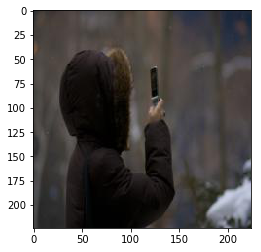

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img=mpimg.imread('./data/images_test/359.jpg')
imgplot=plt.imshow(img)